In [1]:
!pip install -q stellargraph[demos]==1.2.1

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

numba 0.55.1 requires numpy<1.22,>=1.18, but you'll have numpy 1.22.0 which is incompatible.


In [17]:
!pip install -q openpyxl

In [1]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

2022-02-04 10:32:28.650582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/cuda-11.1.1/pytorch/1.8.1_gpu/python3.8/lib:/usr/lib64:/ihome/crc/install/cuda/11.1.1/lib64/stubs:/ihome/crc/install/cuda/11.1.1/lib64
2022-02-04 10:32:28.650621: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-04 10:32:28.651911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

In [2]:
!ls

dummy.xlsx	      GCN-2.ipynb
file_for_network.csv  GCN-3 networkx for tf-pathway.ipynb
foo3.pdf	      GCN.ipynb
foo3.png	      pathway-tf.xlsx
foo.pdf		      tfc_graph_analysis.csv
foo.png


In [3]:
from stellargraph import StellarGraph
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd

In [5]:
xl = pd.ExcelFile("pathway-tf.xlsx")
df = xl.parse("Sheet1", header=None)
df.columns=["pathway","tfs"]
# df=df.head()
df

pathway  \
0                         acute myeloid leukemia   
1                adipocytokine signaling pathway   
2                              pancreatic cancer   
3                     jak stat signaling pathway   
4                         acute myeloid leukemia   
...                                          ...   
1048570                               cell cycle   
1048571                           focal adhesion   
1048572  neuroactive ligand receptor interaction   
1048573                          prostate cancer   
1048574                        pancreatic cancer   

                                                       tfs  
0                                       ['STAT3', 'PRDM1']  
1                                       ['STAT3', 'PRDM1']  
2                                       ['STAT3', 'PRDM1']  
3                                       ['STAT3', 'PRDM1']  
4                                        ['STAT3', 'KLF5']  
...                                                    ...  
1048570  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
1048571  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
1048572  ['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...  
1048573  ['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...  
1048574  ['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...  

[1048575 rows x 2 columns]

In [6]:
df.tfs[1].__class__

str

In [7]:
# import ast
# for i in range(len(df)):
#     x =df.tfs[i]
#     x = ast.literal_eval(x)
#     x = [n.strip() for n in x]
#     df.tfs[i]=x


In [8]:
# x.__class__

In [9]:
# df[['tf1','tf2']] = pd.DataFrame(df.tfs.tolist(), index= df.index)

In [10]:
# df.drop(["tfs"],axis=1, inplace=True)
# df

In [11]:
print(df.shape)
df.head()

(1048575, 2)


pathway                 tfs
0           acute myeloid leukemia  ['STAT3', 'PRDM1']
1  adipocytokine signaling pathway  ['STAT3', 'PRDM1']
2                pancreatic cancer  ['STAT3', 'PRDM1']
3       jak stat signaling pathway  ['STAT3', 'PRDM1']
4           acute myeloid leukemia   ['STAT3', 'KLF5']

In [12]:
df=df.drop_duplicates(subset=['pathway', 'tfs'], keep=False)
df.shape

(42918, 2)

## Networkx

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [14]:
#  # Larger data preperation - SNA of Trump's Person-Person Edge List
# # Edgelist & Adjacency list is created by myself with the dataset above
# df1=pd.read_csv("file_for_network.csv",encoding = "ISO-8859-1", index_col=0)
# df1
# p_a=df1['Gene 1']
# p_b=df1['Gene 2']
# df2=pd.concat([p_a,p_b],axis=0)    
# df2_l=df2.values.tolist() # To count the frequency of names
# # Filter vertices - each one must know 2 or more people
# output = [] # Get unique values 
# for x in p_a:
#     if x not in output:
#         output.append(x)
# for x in p_b:
#     if x not in output:
#         output.append(x)
# #print (output)
# df3=pd.DataFrame(output)
# cnt=[]
# for x in output:
#     cnt.append(df2_l.count(x))
# df3['cnt']=cnt # Add a new column of frequency of the names
# df4=df3
# df4=df4.drop(df3[df3.cnt>1].index) # Get the list the vertices with only 1 target
# df4_l=df4[0].values.tolist()# list the vertices with only 1 target
# # Drop the names who only know one person
# for x in df4_l:
#     df1=df1[~df1['Gene 1'].str.contains(x)]
#     df1=df1[~df1['Gene 2'].str.contains(x)]
# p_a1=df1['Gene 1'].values.tolist()
# p_b1=df1['Gene 2'].values.tolist()
# output2 = [] # Get unique values again
# for x in p_a1:
#     if x not in output2:
#         output2.append(x)
# for x in p_b1:
#     if x not in output2:
#         output2.append(x)

In [15]:
# ## networkx - edgelist
# l=list(zip(p_a1,p_b1)) # EDGELIST
# NetxG1 = nx.Graph()
# NetxG1.add_nodes_from(output2)
# NetxG1.add_edges_from(l)
# #print(list(NetxG1.nodes))
# #print(list(NetxG1.edges))
# plt.figure(figsize=(20,20)) 
# nx.draw(NetxG1,with_labels=True)
# plt.savefig('foo3.png')
# plt.savefig('foo3.pdf')
# plt.show()

In [16]:
tuples = [tuple(x) for x in df.values]

In [42]:
# sns.set()
# plt.figure(figsize=(8,20))
# ax = sns.barplot(x='Total',y='Name',data=npoke_total.sort_values(by='Total', ascending=False).head(25))
# ax.set(xlabel='Overall', ylabel='TF')
# plt.show()

In [ ]:

g = nx.DiGraph()
g.add_edges_from(tuples)
nx.draw_networkx(g)
print(nx.info(g))

DiGraph with 9784 nodes and 42918 edges


In [ ]:
plt.figure(figsize=(20, 20))
pos=nx.spring_layout(g, k=0.15)
nx.draw_networkx(g,pos,node_size=25, node_color='blue')
plt.savefig('tfc_graph.png')
plt.show()

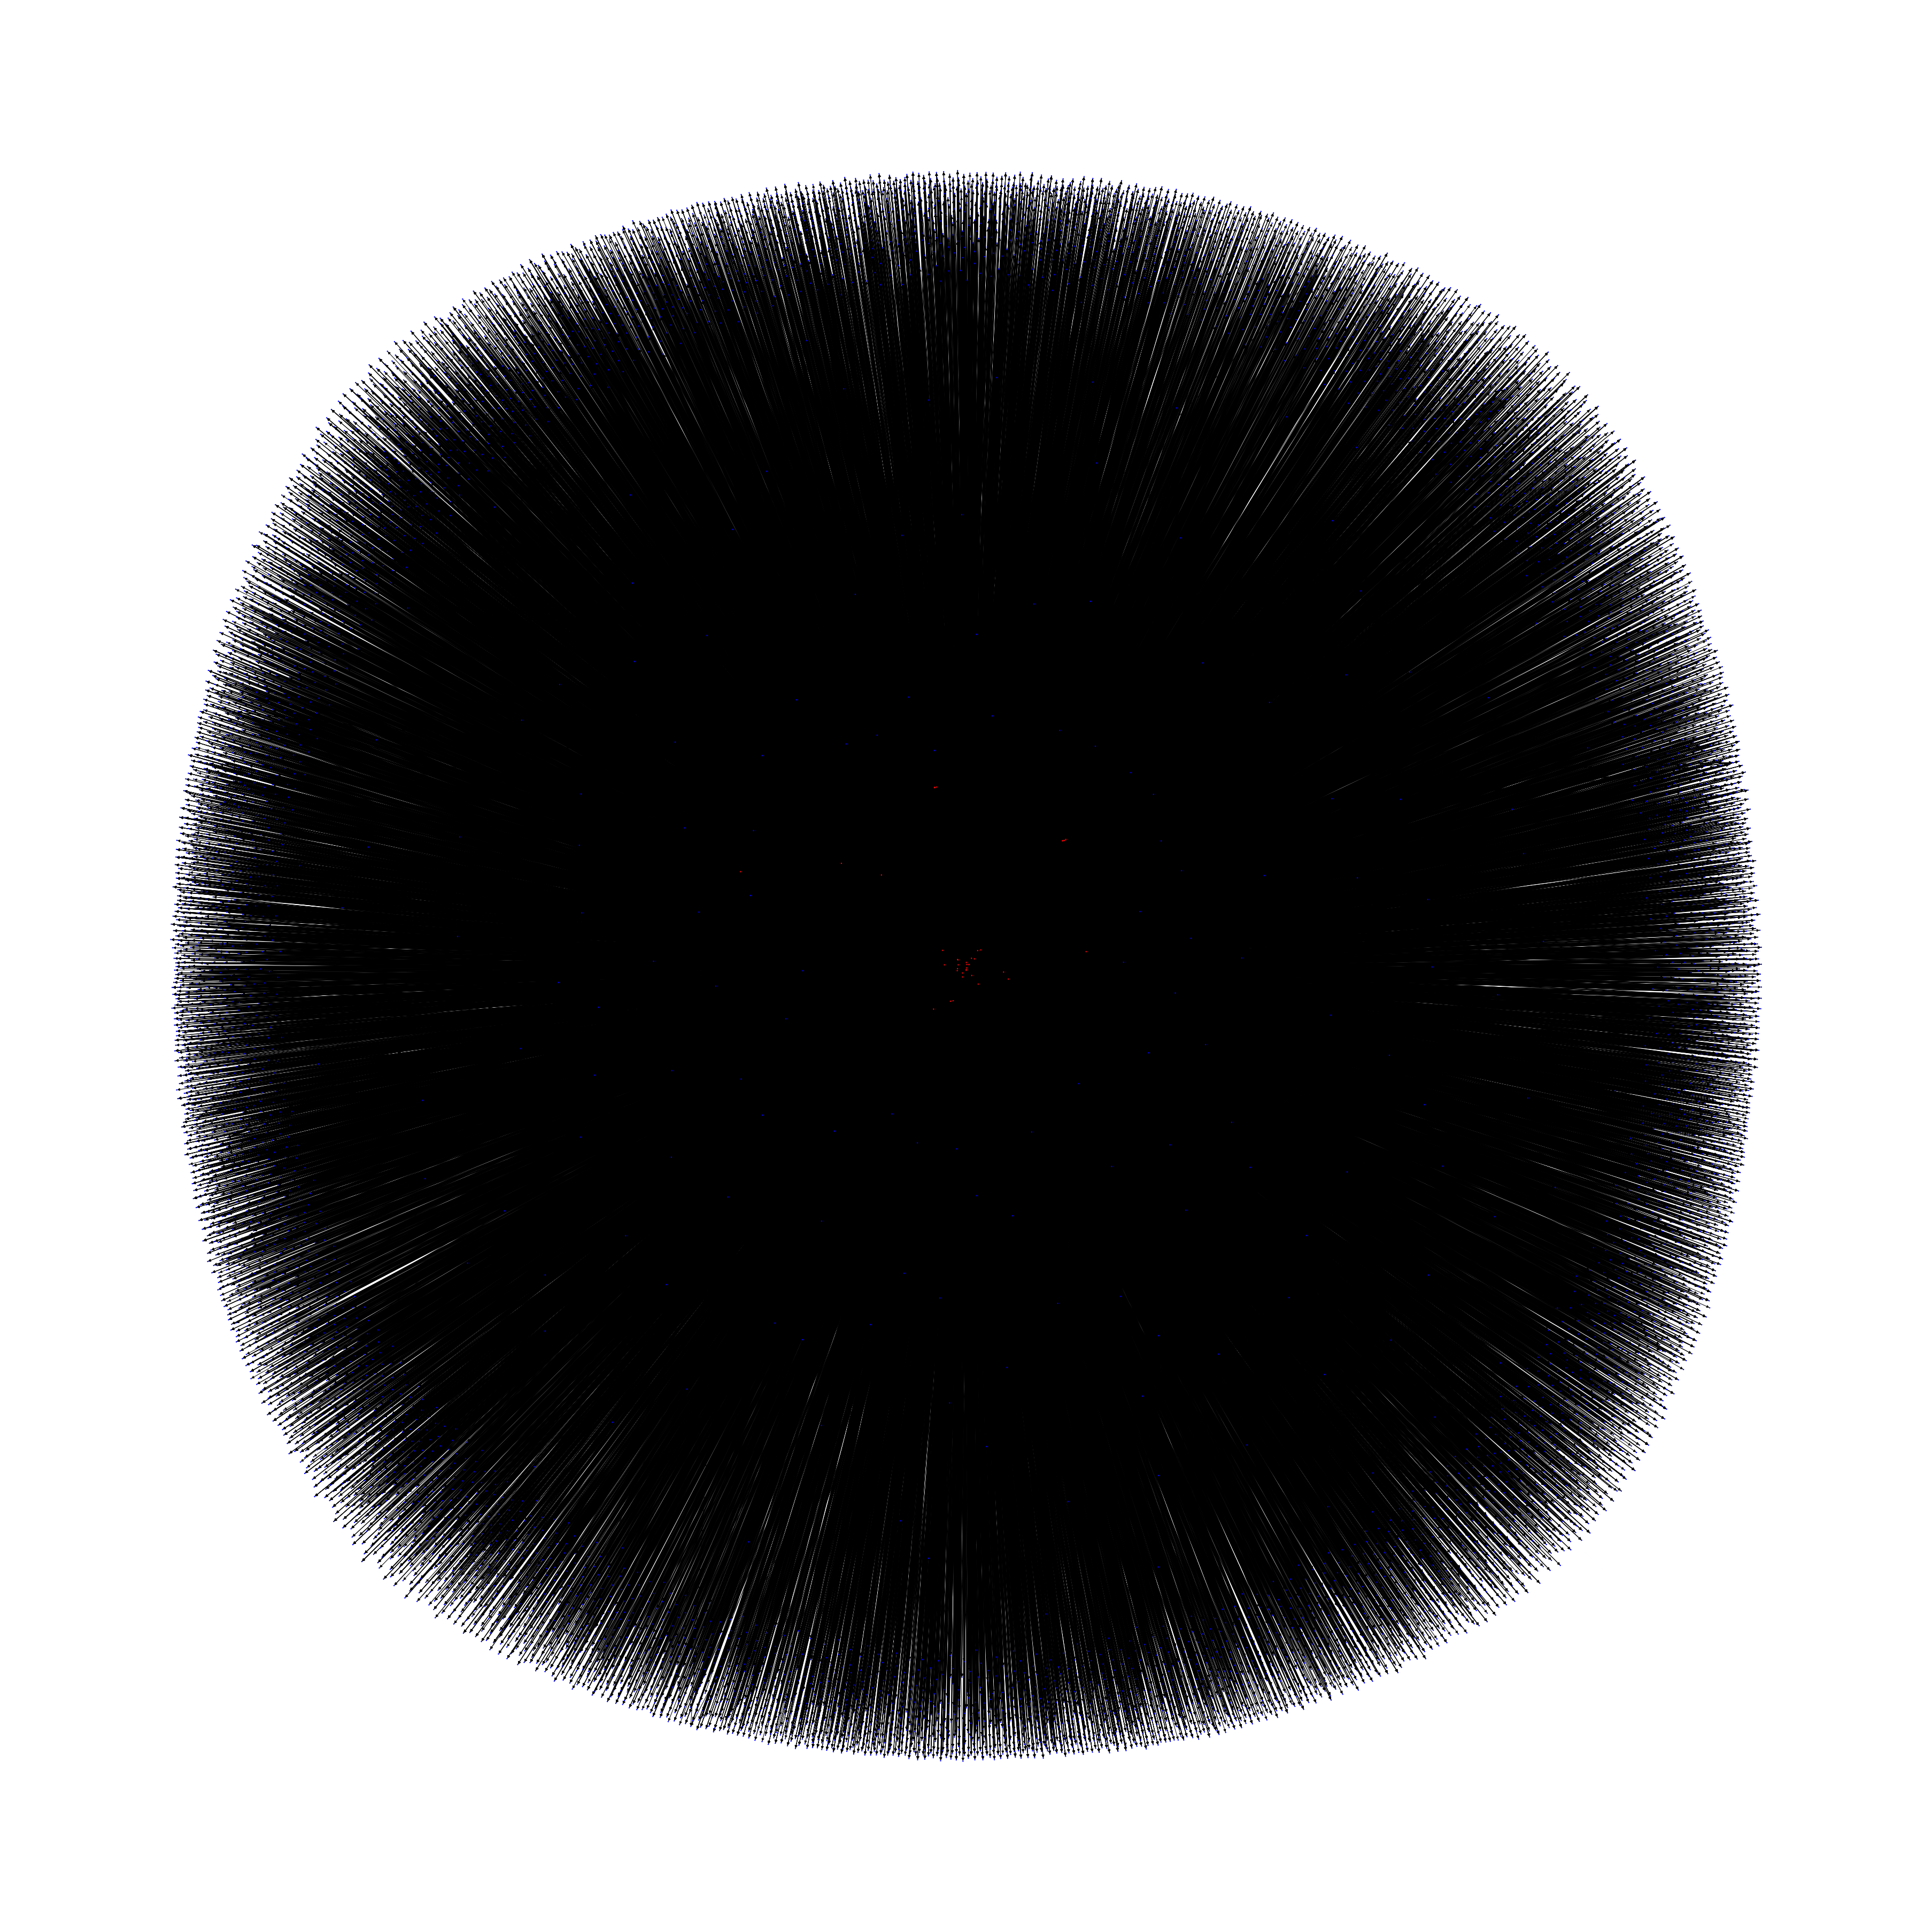

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

G = nx.from_pandas_edgelist(df, source='pathway', target='tfs', \
    create_using=nx.DiGraph)
colors = []
for node in G:
    if node in df["pathway"].values:
        colors.append("red")
    else: colors.append("blue")

# print(colors)
# ['lightblue', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen',
#  'lightblue', 'lightblue', 'lightgreen', 'lightblue', 'lightblue',
#  'lightblue', 'lightblue', 'lightgreen', 'lightgreen']

plt.figure(figsize=(50, 50))
# <Figure size 1500x1000 with 0 Axes>

nx.draw(G, pos = nx.spring_layout(G), \
    node_size=2, node_color=colors, \
    font_size=10, font_weight='bold', with_labels=False)
#linewidths=0.25
plt.savefig('tfc_graph_colour.png')
plt.show()


In [40]:
plt.show()
# plt.savefig('tfc_graph_colour.png')

In [ ]:
# G.edges

In [26]:
import  json
import networkx as nx


def save(G, fname):
    json.dump(dict(nodes=[[n, node[n]] for n in G.nodes()],
                   edges=[[u, v, edge[u][v]] for u,v in G.edges()]),
              open(fname, 'w'), indent=2)

def load(fname):
    G = nx.DiGraph()
    d = json.load(open(fname))
    G.add_nodes_from(d['nodes'])
    G.add_edges_from(d['edges'])
    return G

save(G, "nodes_edges_graph.json")

TypeError: string indices must be integers

In [37]:
# pd.set_option('precision',10)
# G = nx.from_pandas_edgelist(df, 'pathway', 'tfs', create_using = nx.Graph())

# nodes = G.nodes()
# degree = G.degree()
# colors = [degree[n] for n in nodes]
# #size = [(degree[n]) for n in nodes]

# pos = nx.kamada_kawai_layout(G)
# #pos = nx.spring_layout(G, k = 0.2)
# cmap = plt.cm.viridis_r
# cmap = plt.cm.Greys

# vmin = min(colors)
# vmax = max(colors)

# fig = plt.figure(figsize = (15,9), dpi=100)

# nx.draw(G,pos,alpha = 0.8, nodelist = nodes, node_color = 'w', node_size = 10, with_labels= True,font_size = 6, width = 0.2, cmap = cmap, edge_color ='yellow')
# fig.set_facecolor('#0B243B')

# plt.legend()
# plt.show()

In [38]:
################ Analyse ###############

# Calculation of the different coefficients of centrality and storage in a dataframe of independent nodes

# We will create an output dataframe with the nodes and their attributes to store the results of the analysis

# Degree of each node
for i in sorted(G.nodes()):
    G.nodes[i]['Degree'] = G.degree(i)


#extraction of network nodes in a dataframe
nodes_data = pd.DataFrame([i[1] for i in G.nodes(data=True)], index=[i[0] for i in G.nodes(data=True)])
nodes_data = nodes_data.sort_index(ascending= False)
nodes_data.index.names=['ID']
nodes_data.reset_index(level=0, inplace=True)


# Betweenness centrality 
bet_cen = nx.betweenness_centrality(G)
df_bet_cen = pd.DataFrame.from_dict(bet_cen, orient='index')
df_bet_cen.columns = ['betweenness_centrality']
df_bet_cen.index.names = ['ID']
df_bet_cen.reset_index(level=0, inplace=True)
analyse= pd.merge(nodes_data,df_bet_cen, on = ['ID'])

# Clustering coefficient 
clust_coefficients = nx.clustering(G)
df_clust = pd.DataFrame.from_dict(clust_coefficients, orient='index')
df_clust.columns = ['clust_coefficient']
df_clust.index.names = ['ID']
df_clust.reset_index(level=0, inplace=True)
analyse= pd.merge(analyse, df_clust, on = ['ID'])

# Closeness centrality 
clo_cen = nx.closeness_centrality(G)
df_clo = pd.DataFrame.from_dict(clo_cen, orient='index')
df_clo.columns = ['closeness_centrality']
df_clo.index.names = ['ID']
df_clo.reset_index(level=0, inplace=True)
analyse= pd.merge(analyse, df_clo, on = ['ID'])

# Eigenvector centrality
#eig_cen = nx.eigenvector_centrality(G)
#eig_cen = nx.katz_centrality(G)
eig_cen = nx.eigenvector_centrality_numpy(G)
df_eig = pd.DataFrame.from_dict(eig_cen, orient='index')
df_eig.columns = ['eigenvector_centrality']
df_eig.index.names = ['ID']
df_eig.reset_index(level=0, inplace=True)
analyse= pd.merge(analyse, df_eig, on = ['ID'])


print(analyse)

ArpackNoConvergence: ARPACK error -1: No convergence (51 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

In [ ]:
df_analyse = analyse.sort_values(by=['Degree'],ascending=False, inplace=True)
analyse.head()
analyse.to_csv("tfc_graph_analysis.csv")

In [ ]:
plt.show()